# TensorFlow - C11.E08
---

## Data Exploration

In [1]:
# load dataset
import numpy as np
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data ()

x_train.shape, y_train.shape, x_test.shape, y_test.shape

Using TensorFlow backend.


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

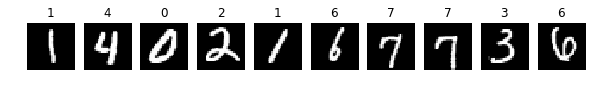

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

n = 10
idx_rnd = np.random.randint (0, x_train.shape[0], n)

fig, axs = plt.subplots (1, n)

for i in range(n):
    axs[i].imshow (x_train[idx_rnd[i]], cmap = 'gray')
    axs[i].set_title (y_train[idx_rnd[i]])
    axs[i].axis ('off')

fig.set_size_inches (10, 10)
plt.show ()

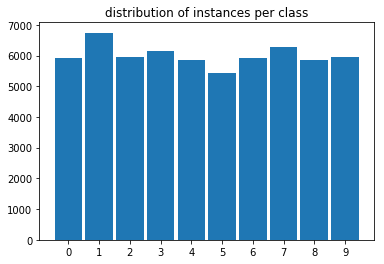

In [3]:
fig, axs = plt.subplots (1, 1)
axs.hist (y_train, range=(0,y_train.max()+1), align = 'left', rwidth = 0.9)
axs.set_xticks (range(y_train.max()+1));
axs.set_title ('distribution of instances per class')
plt.show ()

In [4]:
x_train.min (), x_train.max ()

(0, 255)

## Data Preprocessing
preprocessing steps that are common for all tasks

In [5]:
def split_dataset_at_class (X, y, split_at_class = 0):
    
    max_class = y.max ()
    
    tmp_list_X_low, tmp_list_y_low = [], []
    tmp_list_X_high, tmp_list_y_high = [], []
    
    for i in range (0, max_class+1):
        idx_i = np.where (y == i)[0]
        
        if (i < split_at_class):
            tmp_list_X_low.append (X[idx_i])
            tmp_list_y_low.append (len (idx_i) * [i])
        else:
            tmp_list_X_high.append (X[idx_i])
            tmp_list_y_high.append (len (idx_i) * [i])

    X_low = np.vstack (tmp_list_X_low)
    y_low = np.hstack (tmp_list_y_low)
    X_high = np.vstack (tmp_list_X_high)
    y_high = np.hstack (tmp_list_y_high)
    
    del tmp_list_X_low, tmp_list_y_low, tmp_list_X_high, tmp_list_y_high
    
    return X_low, y_low, X_high, y_high

In [6]:
# split dataset into sets with classes [0, 4] and [5, 9]
# [i] set with classes [5, 9] is used later on for transfer learning
x_train_04, y_train_04, x_train_59, y_train_59 = split_dataset_at_class (x_train, y_train, 5)

(x_train_04.shape, y_train_04.shape), (x_train_59.shape, y_train_59.shape)

(((30596, 28, 28), (30596,)), ((29404, 28, 28), (29404,)))

In [7]:
# do the same for test dataset
x_test_04, y_test_04, x_test_59, y_test_59 = split_dataset_at_class (x_test, y_test, 5)

(x_test_04.shape, y_test_04.shape), (x_test_59.shape, y_test_59.shape)

(((5139, 28, 28), (5139,)), ((4861, 28, 28), (4861,)))

## a. + b. DNN with
- 5 hidden layers of 100 units each
- He initialization
- ELU activation
- \
- Adam optimization
- early stopping
- checkpoint saver
- final model saver
- Softmax output with 5 units

### Data Preprocessing

In [8]:
# build pipeline with preprocessing steps
# [2019-02-08] makes no sense since preprocessing steps are just some lines of code

#### Min-Max Scaling

$x_{std} = \frac {x - x_{min}} {x_{max} - x_{min}}$

$x_{scaled} = x_{std} (max - min) + min$

with (min, max) = new feature range

Applied on the MNIST dataset:

\- all images are scaled with the same minimum (0) and maximum (255).

\- new feature range = [0, 1]

By that, the scaling equation changes to:

$x_{scaled} = x_{std} = \frac {x} {255}$

[i] sklearn's MinMaxScaler is not used since it scales upon min and max per given dataset which can differ

In [9]:
x_train_04 = x_train_04.astype ('f4') / 255
x_test_04 = x_test_04.astype ('f4') / 255
(x_train_04.min (), x_train_04.max ()), (x_test_04.min (), x_test_04.max ())

((0.0, 1.0), (0.0, 1.0))

### Implementation

#### Split dataset
result: train, val, test set

In [10]:
# split into training and validation set
from sklearn.model_selection import train_test_split

# split set with shuffle, since current sets are ordered by class
X_train, X_val, y_train, y_val = train_test_split (
    x_train_04, y_train_04, test_size = 0.25, shuffle = True, random_state = 42
)

# reshape sets, i.e. flatten the image matrices per instance
X_train = X_train.reshape (X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_val = X_val.reshape (X_val.shape[0], X_val.shape[1]*X_val.shape[2])
X_test = x_test_04.reshape (x_test_04.shape[0], x_test_04.shape[1]*x_test_04.shape[2])
y_test = y_test_04

print ('train set:', X_train.shape, y_train.shape)
print ('val set:', X_val.shape, y_val.shape)
print ('test set:', X_test.shape, y_test.shape)

train set: (22947, 784) (22947,)
val set: (7649, 784) (7649,)
test set: (5139, 784) (5139,)


#### TensorFlow MLP

Kernel initialization:

He initialization (also known as MSRA initialization) for ReLU (as well as ELU) with normal distribution:

$\sigma = \sqrt{2} \sqrt{\frac{2}{fan\_in + fan\_out}} = \sqrt{\frac{2}{\frac{fan\_in+fan\_out}{2}}}$

Function <pre>tf.contrib.layers.variance_scaling_initializery</pre> with args:
- factor = 2.0
- mode = 'FAN_AVG' (= $\frac{fan\_in + fan\_out}{2}$)

In [11]:
from mlpmnist import MlpMnist
mlp = MlpMnist (name = 'MlpMnist')

In [12]:
#mlp = MlpMnist (name = 'MlpMnist')
mlp.fit (X_train, y_train, X_val, y_val)

0 , train acc: 1.0 , val acc: 0.97738266
val acc improved, model saved to ./tf_saves/run_MlpMnist/best_acc_val.ckpt
1 , train acc: 1.0 , val acc: 0.9799974
val acc improved, model saved to ./tf_saves/run_MlpMnist/best_acc_val.ckpt
2 , train acc: 1.0 , val acc: 0.9810433
val acc improved, model saved to ./tf_saves/run_MlpMnist/best_acc_val.ckpt
3 , train acc: 1.0 , val acc: 0.9803896
4 , train acc: 1.0 , val acc: 0.9854883
val acc improved, model saved to ./tf_saves/run_MlpMnist/best_acc_val.ckpt
5 , train acc: 1.0 , val acc: 0.986142
val acc improved, model saved to ./tf_saves/run_MlpMnist/best_acc_val.ckpt
6 , train acc: 1.0 , val acc: 0.9852268
7 , train acc: 1.0 , val acc: 0.986142
early stopping after epoch 7


#### Evaluation

In [13]:
# max acc val
print ('score validation set:', mlp._max_acc_val_)
# predictions
print ('score test set:', mlp.score (X_test, y_test))

score validation set: 0.986142
INFO:tensorflow:Restoring parameters from ./tf_saves/run_MlpMnist/best_acc_val.ckpt
score test set: 0.99241096


In [14]:
y_pred, y_pred_distr = mlp.predict (X_test)

INFO:tensorflow:Restoring parameters from ./tf_saves/run_MlpMnist/best_acc_val.ckpt


__TODO__: check distribution of wrong predictions and find out why these predictions were made

## c. Grid Search w/ Cross Validation

Exhaustive grid search with k-fold cross validation is applied to find the best hyperparameters for the used MLP architecture.

Hereby, the original training set is split into k subsets, which are then used to train a MLP with specific hyperparameters by
- iterating through every subset as the current validation set
- train the MLP on the remaining subsets
- save validation and test accuracy of best run

Since the training time is short, grid search can be used here. If training time is too long, it is advised to take randomized search.

In [16]:
x_train_04.shape, y_train_04.shape

((30596, 28, 28), (30596,))

In [17]:
# make stratified folds of the dataset to preserve a balanced distribution of samples over classes
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold (n_splits = 4, shuffle = False, random_state = 42)
skf

StratifiedKFold(n_splits=4, random_state=42, shuffle=False)

In [18]:
# grid search parameter sets
import itertools as it

# parameter grid
param_grid = {
    'lr' : [0.1, 0.001, 0.0001],
    'beta1' : [0.9, 0.7, 0.5],
    'beta2' : [0.999, 0.799, 0.599]
}

# make every possible combination of parameter values
param_combinations = list (it.product (*param_grid.values ()))
len (param_combinations)

27

In [19]:
# also see function StratifiedShuffleSplit
from collections import defaultdict

# shuffle dataset first
x_train_04, _, y_train_04, _ = train_test_split (
    x_train_04, y_train_04, test_size = 0.0, train_size = None, shuffle = True, random_state = 42
)


cv_results = defaultdict (list)

i = 0
for pc in param_combinations:
    
    name = 'mlpkfold_{}'.format (i)
    
    print ('[i]', name, pc)
    
    cv_results[name].append (pc)
    
    cur_mlp = MlpMnist (
        name = name,
        lr = pc[0],
        beta1 = pc[1],
        beta2 = pc[2]
    )
    
    acc_val_list = []
    acc_test_list = []
    for train_idx, val_idx in skf.split (x_train_04, y_train_04):
        X_train, X_val = x_train_04[train_idx], x_train_04[val_idx]
        y_train, y_val = y_train_04[train_idx], y_train_04[val_idx]

        X_train = X_train.reshape (X_train.shape[0], X_train.shape[1]*X_train.shape[2])
        X_val = X_val.reshape (X_val.shape[0], X_val.shape[1]*X_val.shape[2])

        cur_mlp.fit (X_train, y_train, X_val, y_val)
        acc_val_list.append (cur_mlp._max_acc_val_)
        acc_test_list.append (cur_mlp.score (X_test, y_test))
    
    cv_results[name].append (acc_val_list)
    cv_results[name].append (acc_test_list)
    
    i += 1

[i] mlpkfold_0 (0.1, 0.9, 0.999)
0 , train acc: 0.2 , val acc: 0.20036596
val acc improved, model saved to ./tf_saves/run_mlpkfold_0/best_acc_val.ckpt
1 , train acc: 0.2 , val acc: 0.20036596
2 , train acc: 0.2 , val acc: 0.19356947
early stopping after epoch 2
INFO:tensorflow:Restoring parameters from ./tf_saves/run_mlpkfold_0/best_acc_val.ckpt
0 , train acc: 0.4 , val acc: 0.3637433
val acc improved, model saved to ./tf_saves/run_mlpkfold_0/best_acc_val.ckpt
1 , train acc: 0.2 , val acc: 0.22036335
2 , train acc: 0.2 , val acc: 0.22036335
early stopping after epoch 2
INFO:tensorflow:Restoring parameters from ./tf_saves/run_mlpkfold_0/best_acc_val.ckpt
0 , train acc: 0.2857143 , val acc: 0.1936454
1 , train acc: 0.17857143 , val acc: 0.22031903
2 , train acc: 0.17857143 , val acc: 0.22031903
early stopping after epoch 2
INFO:tensorflow:Restoring parameters from ./tf_saves/run_mlpkfold_0/best_acc_val.ckpt
0 , train acc: 1.0 , val acc: 0.6619147
val acc improved, model saved to ./tf_sav

### Evaluation

In [20]:
# make a clean version of cv_results as DataFrame
import pandas as pd

df_data = []
for cv_mlp in cv_results:
    data = [cv_mlp] + [param for param in cv_results[cv_mlp][0]] +\
    [np.mean (cv_results[cv_mlp][1])] + [np.std (cv_results[cv_mlp][1])] +\
    [np.mean (cv_results[cv_mlp][2])] + [np.std (cv_results[cv_mlp][2])]
    df_data.append (data)


col_names = ['estimator_name'] + [x for x in param_grid.keys ()] + ['acc_val_mean', 'acc_val_std', 'acc_test_mean', 'acc_test_std']
cv_results_pd = pd.DataFrame (df_data, columns = col_names)

In [21]:
cv_results_pd

,estimator_name,lr,beta1,beta2,acc_val_mean,acc_val_std,acc_test_mean,acc_test_std
0,mlpkfold_0,0.1000,0.9,0.999,0.436907,0.230893,0.435347,0.233811
1,mlpkfold_1,0.1000,0.9,0.799,0.200405,0.000039,0.196536,0.000000
2,mlpkfold_2,0.1000,0.9,0.599,0.000000,0.000000,-1.000000,0.000000
3,mlpkfold_3,0.1000,0.7,0.999,0.906025,0.000000,0.919634,0.000000
4,mlpkfold_4,0.1000,0.7,0.799,0.213665,0.011602,0.213320,0.013060
5,mlpkfold_5,0.1000,0.7,0.599,0.220363,0.000000,0.220860,0.000000
6,mlpkfold_6,0.1000,0.5,0.999,0.953078,0.000000,0.964390,0.000000
7,mlpkfold_7,0.1000,0.5,0.799,0.220363,0.000000,0.220860,0.000000
8,mlpkfold_8,0.1000,0.5,0.599,0.207532,0.012787,0.210839,0.010021
9,mlpkfold_9,0.0010,0.9,0.999,0.986273,0.002250,0.990319,0.000540


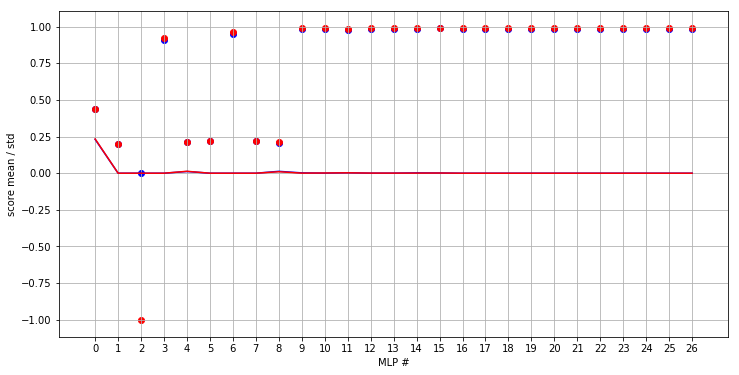

In [22]:
fig, axs = plt.subplots (1, 1)

axs.scatter (
    x = cv_results_pd.index.values,
    y = cv_results_pd['acc_val_mean'].values,
    color = 'b'
)
axs.plot (
    cv_results_pd['acc_val_std'].values,
    color = 'b'
)

axs.scatter (
    x = cv_results_pd.index.values,
    y = cv_results_pd['acc_test_mean'].values,
    color = 'r'
)
axs.plot (
    cv_results_pd['acc_test_std'].values,
    color = 'r'
)

axs.set_xticks (cv_results_pd.index.values)
axs.grid (True)

axs.set_xlabel ('MLP #')
axs.set_ylabel ('score mean / std')

fig.set_size_inches (12, 6)

plt.show ()

best estimator:
- blue and red dot close together
- blue and red mean score high
- blue and red std low

take a closer look at MLPs #10 to #26

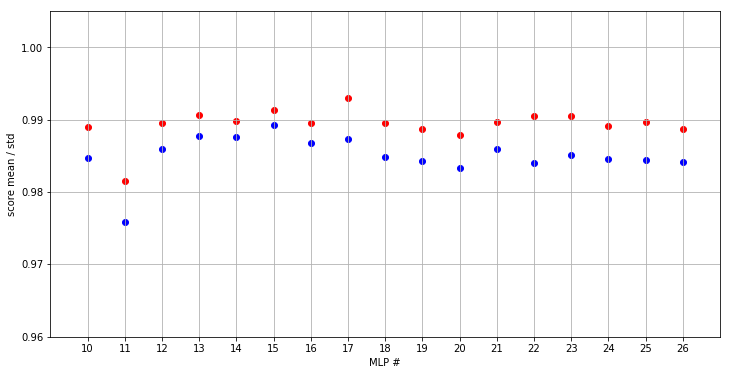

In [38]:
mlp_idx = list (range (10, 27))

fig, axs = plt.subplots (1, 1)

axs.scatter (
    x = cv_results_pd.iloc[mlp_idx].index.values,
    y = cv_results_pd.iloc[mlp_idx]['acc_val_mean'].values,
    color = 'b'
)

axs.scatter (
    x = cv_results_pd.iloc[mlp_idx].index.values,
    y = cv_results_pd.iloc[mlp_idx]['acc_test_mean'].values,
    color = 'r'
)

axs.set_xlim ([9, 27])
axs.set_xticks (cv_results_pd.iloc[mlp_idx].index.values)
axs.grid (True)

axs.set_xlabel ('MLP #')
axs.set_ylabel ('score mean / std')

fig.set_size_inches (12, 6)

plt.show ()

test score is always greater than val score,

best test score: MLP #17

best val score: MLP #15

smallest distance between test and val score: MLP #15

In [39]:
cv_results_pd.iloc[15]

estimator_name    mlpkfold_15
lr                      0.001
beta1                     0.5
beta2                   0.999
acc_val_mean         0.989248
acc_val_std        0.00158138
acc_test_mean        0.991389
acc_test_std       0.00121035
Name: 15, dtype: object

## Retrain current best estimator

In [40]:
# retrain best estimator
print ('train set:', X_train.shape, y_train.shape)
print ('val set:', X_val.shape, y_val.shape)
print ('test set:', X_test.shape, y_test.shape)

train set: (22950, 784) (22950,)
val set: (7646, 784) (7646,)
test set: (5139, 784) (5139,)


In [41]:
# hyperparameters of MLP #22
mlp_best = MlpMnist (
    name = 'MlpBest',
    lr = 0.001,
    beta1 = 0.5,
    beta2 = 0.999
)

mlp_best.fit (X_train, y_train, X_val, y_val)

0 , train acc: 1.0 , val acc: 0.97397333
val acc improved, model saved to ./tf_saves/run_MlpBest/best_acc_val.ckpt
1 , train acc: 1.0 , val acc: 0.9870521
val acc improved, model saved to ./tf_saves/run_MlpBest/best_acc_val.ckpt
2 , train acc: 1.0 , val acc: 0.97567356
3 , train acc: 1.0 , val acc: 0.98443633
early stopping after epoch 3


In [42]:
mlp_best.score (X_test, y_test)

INFO:tensorflow:Restoring parameters from ./tf_saves/run_MlpBest/best_acc_val.ckpt


0.98910296

### Evaluate wrong predicitons

In [43]:
y_pred, y_pred_distr = mlp_best.predict (X_test)

INFO:tensorflow:Restoring parameters from ./tf_saves/run_MlpBest/best_acc_val.ckpt


In [44]:
y_test_ev = y_test.reshape (-1, 1)
y_pred_ev = y_pred.reshape (-1, 1)
y_pred_distr_ev = np.round (y_pred_distr*100, 2)

In [45]:
import pandas as pd

y_test_pred = np.concatenate ((y_test_ev, y_pred_ev, y_pred_distr_ev), axis=1)

y_test_pred_df = pd.DataFrame (
    y_test_pred,
    columns = ['y_test', 'y_pred', 'y_pred_d_0', 'y_pred_d_1', 'y_pred_d_2', 'y_pred_d_3', 'y_pred_d_4'],
    dtype = 'i4'
)
y_test_pred_df.head (3)

,y_test,y_pred,y_pred_d_0,y_pred_d_1,y_pred_d_2,y_pred_d_3,y_pred_d_4
0,0,0,100,0,0,0,0
1,0,0,100,0,0,0,0
2,0,0,100,0,0,0,0


In [46]:
y_diff_df = y_test_pred_df[y_test_pred_df['y_test'] != y_test_pred_df['y_pred']]
print (y_diff_df.shape)
display (y_diff_df)

(56, 7)


,y_test,y_pred,y_pred_d_0,y_pred_d_1,y_pred_d_2,y_pred_d_3,y_pred_d_4
202,0,2,45,0,54,0,0
376,0,2,0,0,84,0,13
417,0,3,12,0,0,87,0
634,0,2,45,0,46,0,7
691,0,3,11,0,0,87,0
942,0,3,0,4,3,91,0
1090,1,3,0,9,0,90,0
1097,1,2,0,4,94,0,0
1160,1,3,0,21,3,74,0
1231,1,2,0,1,98,0,0


In [49]:
y_diff_idx = y_diff_df.index.values
X_diff = X_test[y_diff_idx]
X_diff_img = X_diff.reshape (X_diff.shape[0], 28, 28)

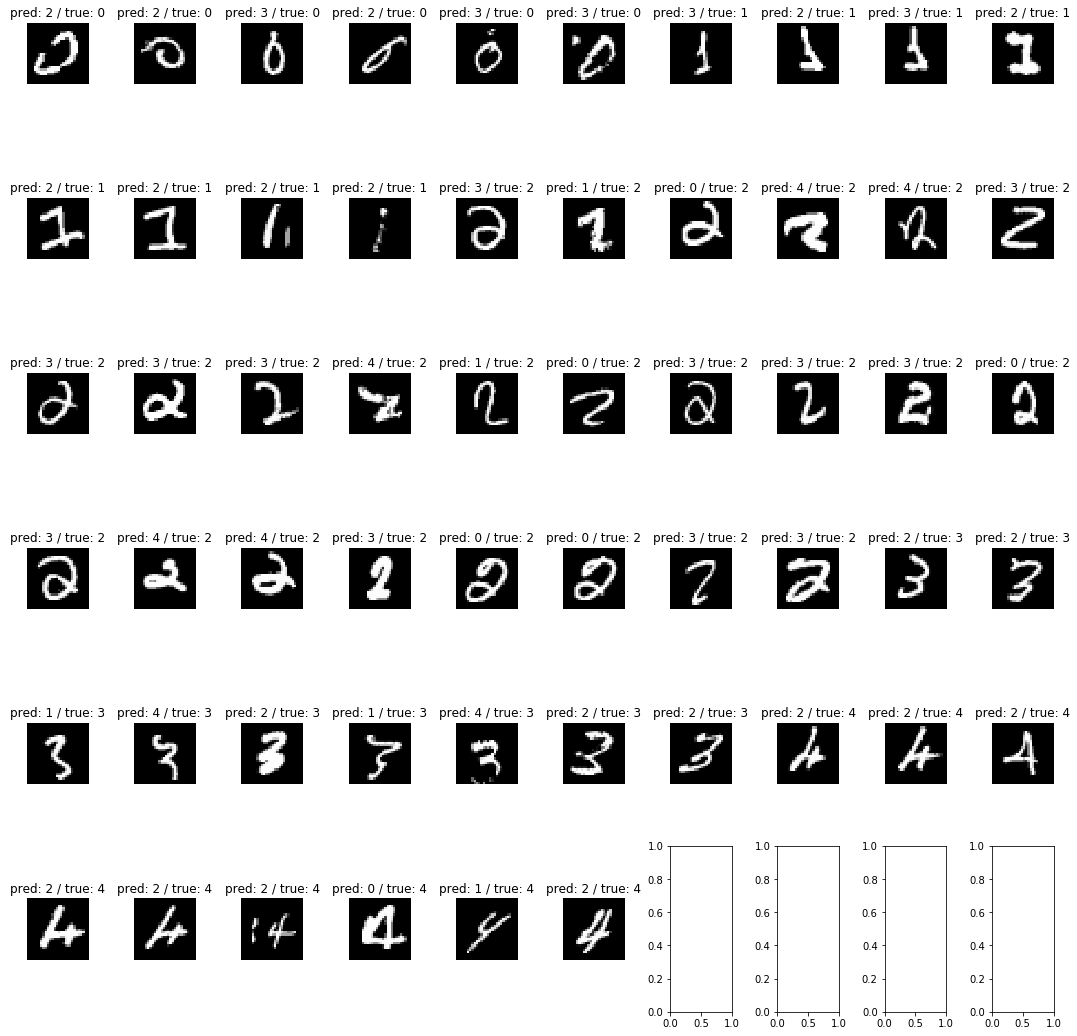

In [61]:
img_per_col = 10
num_rows = int (np.ceil (X_diff_img.shape[0] / img_per_col))

fig, axs = plt.subplots (num_rows, img_per_col)

i, j = 0, 0
for k in range (num_rows*img_per_col):
    
    if (k >= X_diff_img.shape[0]):
        break
    
    axs[i][j].imshow (X_diff_img[k], cmap = 'gray')
    axs[i][j].set_title ('pred: {} / true: {}'.format (y_diff_df.iloc[k][1], y_diff_df.iloc[k][0]))
    axs[i][j].axis ('off')
    
    j += 1
    if (j%img_per_col == 0):
        i += 1
        j = 0

fig.set_size_inches (15, 15)
plt.tight_layout ()
plt.show ()

__Result__

For most of the wrong predicted instances it is very clear to the human eye which digit it should represent.

Further investigation has to be made to find out why these instances were incorrectly predicted.

## Test with own handwritten digits

In [119]:
import numpy as np
from PIL import Image

im_path = './src/c-major-scale-on-treble-clef.graph.png'
im = Image.open (im_path).convert ('L')
print ('[i] image size:', im.size)
print ('[i] pixel format:', im.mode)

[i] image size: (233, 496)
[i] pixel format: L


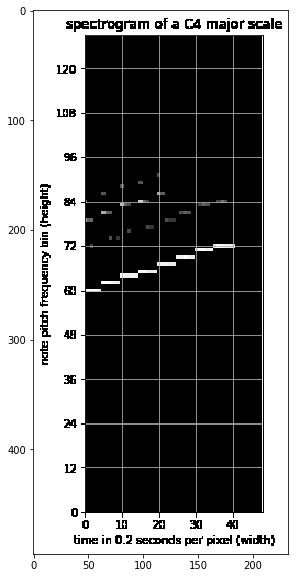

In [120]:
fig, axs = plt.subplots (1, 1)

axs.imshow (im)

fig.set_size_inches (10, 10)
plt.show ()

In [121]:
im_arr = np.array (im)
# add instance axis
im_arr = im_arr[np.newaxis, :, :]
# flatten
im_arr = im_arr.reshape (im_arr.shape[0], im_arr.shape[1]*im_arr.shape[2])

im_arr.shape

(1, 115568)

In [163]:
X_pred = np.ndarray ((1,28*28))

In [164]:
myMnistEst = MlpMnist (
    name = 'myMnistEst',
    restore_ckpt = './tf_saves/run_MlpBest/best_acc_val.ckpt'
)

y_pred, y_pred_distr = myMnistEst.predict (X_pred)

INFO:tensorflow:Restoring parameters from ./tf_saves/run_MlpBest/best_acc_val.ckpt


## TODO

### k-fold cross validation with sklearn's GridSearchCV
Does not work currently due to:

'Cannot clone object '<__main__.MlpMnist object at 0x0000015B4E127978>' (type <class '__main__.MlpMnist'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' methods.'

In [296]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'lr' : [0.1, 0.01, 0.001, 0.0001],
    'beta1' : [0.9],
    'beta2' : [0.999]
}

mlpkfold = MlpMnist (name = 'mlpkfold')

gscv = GridSearchCV (
    estimator = mlpkfold,
    param_grid = param_grid,
    cv = skf,
    n_jobs = 1,
    refit = False
)
gscv

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=False),
       error_score='raise-deprecating',
       estimator=<__main__.MlpMnist object at 0x0000015B5370D908>,
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'lr': [0.1, 0.01, 0.001, 0.0001], 'beta1': [0.9], 'beta2': [0.999]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring=None, verbose=0)

In [297]:
# shuffle dataset first
#x_train_04, _, y_train_04, _ = train_test_split (
#    x_train_04, y_train_04, test_size = 0.0, train_size = None, shuffle = True, random_state = 42
#)

#gscv.fit (x_train_04, y_train_04)